# News Classification

We will use the BBC News dataset, containing 2,225 labeled news articles across five categories: business, entertainment, politics, sport, and tech. The dataset is split into 1,490 articles for training and 735 for testing. The objective is to build a classification model that can accurately predict the category of previously unseen news articles. 

The model's performance will be evaluated using **Accuracy** as the primary metric.

In [1]:
import pandas as pd
import numpy as np

import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data Input and Pre-processing

We will load the BBC News dataset from a local CSV file. The dataset consists of two columns: the article text and its corresponding category. For easier processing, we will encode the categorical variable (news category) into integers, as many machine learning algorithms perform better with numerical representations of categorical data.

The pre-processing steps include:

1. **Loading the dataset**: The data will be loaded from a CSV file using Pandas.
2. **Category Encoding**: Each category (business, entertainment, politics, sport, tech) will be mapped to an integer using `LabelEncoder`.
3. **Text Vectorization**: We will use `TfidfVectorizer` to transform the text into a numerical format suitable for model training by converting it into TF-IDF scores.
4. **Train-Test Split**: The dataset will be split into 1,490 training samples and 735 testing samples for model evaluation.

The dataset can also be obtained from its original source [BBC News Classification Dataset](http://mlg.ucd.ie/datasets/bbc.html).

By performing these steps, we ensure the data is prepared for building a classification model capable of predicting the news category based on the article content.


In [2]:
# Load data
data_path = r"dataset/BBC_News_Train.csv"
data = pd.read_csv(data_path)

# Use factorize to prepare the CategoryId
data['CategoryId'] = data.Category.factorize()[0]

category_df = data[['Category','CategoryId']].drop_duplicates().sort_values('CategoryId')
category2id = dict(category_df.values)
id2category = dict(category_df[['CategoryId','Category']].values)

### Data Inspection

Data inspection helps us understand the dataset, identify inconsistencies, and assess its quality. Key tasks include:

1. **Check for Missing Values**: Ensure no missing data in the text or category columns.
2. **Category Distribution**: Visualize the number of articles per category to detect any imbalances.
3. **Text Lengths**: Analyze article length to spot outliers.
4. **Sample Review**: Manually inspect a few samples for correctness.

This step informs the data cleaning and feature engineering processes.


In [3]:
# Check the shape of the data
data.shape

# Check the column names
data.columns

# Check for missing values
data.isnull().sum()

# Look at the first few rows
data.head()

# Check the distribution of categories
data['Category'].value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

Base on above data inspection, we see that the data quality is good, no data cleaning is needed.

### Text Preprocessing

The goal of text preprocessing is to transform raw text data into a structured format suitable for analysis and modeling. By applying techniques such as:

1. **Tokenization**: Breaking text into individual words or tokens.

2. **Stemming/Lemmatization**: Reducing words to their root form to handle variations (e.g., "running" to "run").
   
3. **Stopword Removal**: Removing common words (e.g., "and", "the") that add little value to the analysis.

4. **Normalization**: Converting text to lowercase, removing punctuation, and handling special characters.

These steps reduce dimensionality, standardize the data, and enhance model performance for classification.


In [4]:
# Loading necessary resources
def load_stopwords():
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')

load_stopwords()

# Function to preprocess text
def preprocess_text(text):
    # Tokenization
    words = nltk.word_tokenize(text=text, language='english')

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

# Ensure data is a DataFrame and handle null values
data['Text'] = data['Text'].fillna('')  # Handle NaN values
data['Text'] = data['Text'].astype(str)  # Ensure text column is strings

# Apply preprocessing
data['CleanText'] = data['Text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration

Before training models, it's essential to understand the dataset's structure. This helps shape our problem-solving approach.

Key steps include:

- **Reviewing Random Samples**: Look at random examples to familiarize ourselves with the content.

- **Class Distribution**: Check the number of examples in each category to identify potential class imbalances.


In [5]:
data.sample(5, random_state=0)

,ArticleId,Text,Category,CategoryId,CleanText
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4,focker fuel festiv film chart comedi meet fock...
354,1349,tory candidate quits over remark a conservativ...,politics,2,tori candid quit remark conserv elect challeng...
1227,1572,bath faced with tindall ultimatum mike tindall...,sport,3,bath face tindal ultimatum mike tindal agent w...
907,1155,chancellor rallies labour voters gordon brown ...,politics,2,chancellor ralli labour voter gordon brown iss...
575,307,young debut cut short by ginepri fifteen-year-...,sport,3,young debut cut short ginepri fifteen-year-old...


Show the number of documents per category:

<Axes: xlabel='Category'>

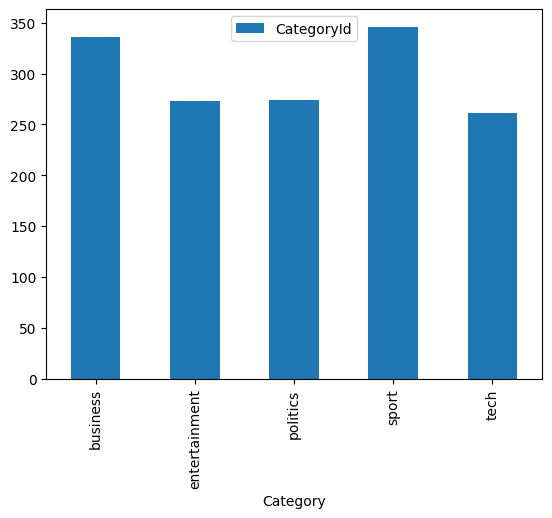

In [6]:
data[['Category','CategoryId']].groupby('Category').count().plot.bar(ylim=0)

The class distribution reveals that the number of articles per category is roughly balanced, which is ideal. If the dataset were imbalanced, we would need to adjust our model or apply techniques like oversampling/undersampling to address the imbalance.


Show the Word Cloud of the articles:

(-0.5, 799.5, 399.5, -0.5)

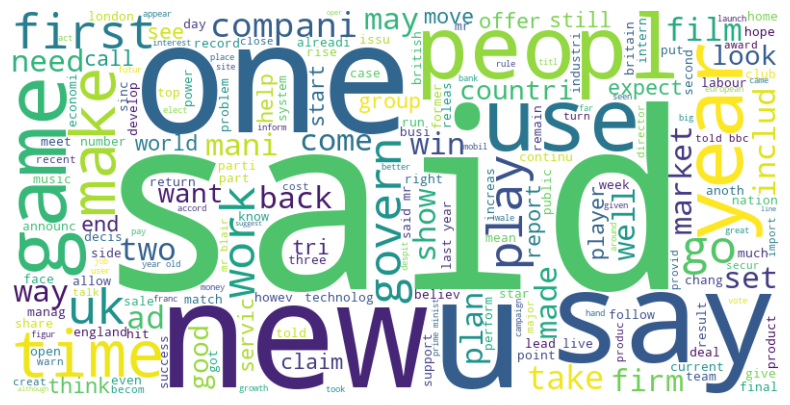

In [7]:
text = ' '.join(data['CleanText'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

By analyzing the Word Cloud, we can observe the following:

- **High-Frequency Function Words**: Words like "said," "say," "one," and "people" are commonly used function words in English that may not contribute significantly to topic classification.
  
- **Specific Topics**: Words such as "film," "govern," and "company" indicate specific themes related to entertainment or political topics, which are more relevant for classification purposes.


Show the Word Frequency of the articles:

In [8]:
def get_word_counts(text_data):
  all_words = []
  for text in text_data:
    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    all_words.extend(words)
  word_counts = Counter(all_words)
  word_freq = pd.DataFrame({'word': list(word_counts.keys()), 'count': list(word_counts.values())})
  word_freq = word_freq.sort_values(by='count', ascending=False)
  return word_freq

word_freq = get_word_counts(data['CleanText'])
word_freq.head(20)

,word,count
75,said,4838
39,mr,2006
112,year,1853
160,would,1711
83,also,1426
65,new,1334
286,peopl,1324
27,us,1234
384,one,1190
336,say,1050


```markdown
Based on the Word Frequency data, the following observations can be made:

- **Common Function Words**: Words like "said," "would," "also," and "could" are frequent function words commonly used in language.

- **Potential Topics**: Terms such as "people," "government," "time," and "year" suggest a focus on social or political themes.

- **Specific Domains**: Words like "game," "film," and "tech" (if present) may indicate specific domains or subject matters relevant to the articles.
```

## Building and training models

### Feature Extraction

To analyze our dataset using machine learning methods, we need to convert each article's text into a feature vector. We will use **TF-IDF (Term Frequency-Inverse Document Frequency)** to capture the importance of words within individual documents and across the entire dataset. This process creates a document-term matrix where:

- **Rows** represent individual documents (articles).

- **Columns** represent unique words.

This transformation enables the model to effectively interpret the textual data based on the significance of terms within the context of the dataset.


In [9]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=5000, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = vectorizer.fit_transform(data.Text).toarray()
features.shape

(1490, 5000)

### Non-Negative Matrix Factorization (NMF)

We will apply Non-Negative Matrix Factorization (NMF) to the document-term matrix. NMF decomposes the matrix into two lower-dimensional matrices:

- **W (Document-Topic Matrix)**: Each row represents a document, and each column represents a topic. The values indicate the weights (or contributions) of each topic to a specific document.

- **H (Topic-Term Matrix)**: Each row represents a topic, and each column represents a word. The values indicate the importance of each word in describing a particular topic.


We will create an NMF model with `n_components=5` and `random_state=42`. We may adjust some hyperparameters later to enhance predictive accuracy.


In [10]:
# Define the number of topics
num_topics = 5

# Training the NMF model
nmf = NMF(n_components=num_topics, random_state=42)
topic_matrix = nmf.fit_transform(features)

### Analyzing the Topic-Term Matrix (H)

We will analyze the `H` matrix (topic-term matrix) to gain insights into the discovered topics. In this matrix, words with high values in a specific column are the most relevant to that particular topic. 

To identify the most significant words associated with each topic, we will use the `argmax()` function, which helps us pinpoint the words with the highest weights in each column. This analysis will allow us to interpret the underlying themes represented by the NMF model and better understand the content of the dataset.


In [11]:
# Assign topics to articles
data['predicted_topic'] = topic_matrix.argmax(axis=1)

As observed, the `factorize()` function assigns integer labels starting from 0 to \( n-1 \) for \( n \) unique labels, while the NMF topics are also numbered from 0 to \( n-1 \). However, these two sets of numbers may not align directly, which can lead to confusion in interpretation.

To improve clarity, we will modify our approach to ensure that the labels of the discovered topics align more closely with the corresponding categories in our dataset. This can be achieved by mapping the NMF topics to the original category labels based on their highest contribution, allowing for a more intuitive understanding of the results.


In [12]:
# Align NMF topics with given labels
def alignTopicToLabel():
    topic_to_label = {}
    for topic in range(num_topics):
        labels = data[data['predicted_topic'] == topic]['CategoryId']
        if len(labels) > 0:
            topic_to_label[topic] = labels.mode().iloc[0]
        else:
            topic_to_label[topic] = -1  # Assign -1 if no articles in this topic
    return topic_to_label
topic_to_label = alignTopicToLabel()
data['aligned_topic'] = data['predicted_topic'].map(topic_to_label)

This approach aligns the NMF topics with the encoded labels based on the most frequent label in each topic. By doing so, we enable a more meaningful comparison between the discovered topics and the true labels.

It's important to note that this alignment serves as a post-hoc interpretation of the NMF results. The effectiveness of this alignment depends on how well the discovered topics correspond to the actual categories present in the dataset. Therefore, while this method enhances interpretability, its accuracy is contingent upon the quality of the topic modeling.


Next, we can uncover the representation of each topic by analyzing the NMF components. By examining the most important words associated with each topic, we can interpret and label them in a human-readable format. 

This process is particularly valuable in unsupervised learning scenarios, where we lack predefined labels or categories. By deriving meaningful labels from the identified words, we can better understand the underlying themes in the data and enhance the interpretability of our model's results.


In [13]:
# Get the most important words for each topic
feature_names = vectorizer.get_feature_names_out()
word_importance = nmf.components_

for topic_idx, topic in enumerate(word_importance):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_topics - 1:-1]]
    topic_name = id2category[topic_to_label[topic_idx]]
    print(f"Topic {topic_name}: {', '.join(top_words)}")

Topic tech: people, users, technology, mobile, digital
Topic sport: game, win, england, cup, team
Topic politics: mr, labour, election, blair, party
Topic entertainment: film, best, awards, actor, award
Topic business: growth, said, market, economy, year


Based on the analysis of the top words, it appears that the NMF model has successfully identified distinct topics within the dataset. We can leverage this approach to analyze the test dataset as well, applying the same topic modeling techniques to uncover underlying themes and enhance our understanding of the articles in the test set. This will help us evaluate the model's effectiveness in categorizing previously unseen data.


## Model Evaluation

Evaluating model performance is a crucial step in machine learning, as it helps us assess how well our model generalizes to unseen data and achieves the desired outcomes. The `classification_report` function from scikit-learn offers several benefits for evaluating the performance of a classification model:

- **Detailed Breakdown**: It provides a comprehensive overview of the model's performance for each class in a multi-class classification problem, including metrics such as **Precision**, **Recall**, **F1-score**, and **Support**.

- **Averaging Metrics**: It calculates both macro and weighted averages of these metrics, offering a summary of the model's overall performance across all classes, facilitating easier interpretation of the results.


In [14]:
target_names = data.Category.unique()
print("\nClassification Report:")
print(classification_report(data.CategoryId, data['aligned_topic'], target_names=target_names))


Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.97      0.95       336
         tech       0.92      0.93      0.93       261
     politics       0.96      0.95      0.95       274
        sport       0.95      0.99      0.97       346
entertainment       0.98      0.88      0.92       273

     accuracy                           0.95      1490
    macro avg       0.95      0.94      0.94      1490
 weighted avg       0.95      0.95      0.95      1490



Based on the classification report, we can draw the following conclusions:

- **Accuracy**: The model achieves an accuracy of 0.95, indicating that it correctly classified 95% of the documents.

- **Macro and Weighted Averages**: The macro and weighted averages for precision, recall, and F1-score are all around 0.95, suggesting consistent performance across all categories.

- **Individual Class Performance**: Each category has precision, recall, and F1-score values above 0.90, indicating strong performance for all topics. 

  - The **"Sport"** category has the highest recall (0.99), suggesting that the model rarely misses relevant sports articles.

  - The **"Business"** category has the lowest precision (0.93), indicating that there may be a few false positives in this category.


We can identify misclassifications from the classification report, and visualizing the confusion matrix provides valuable insights. The confusion matrix helps us determine how many articles were correctly classified for each category and how many were misclassified into other categories, allowing us to identify common mistakes made by the model.

In the confusion matrix:

- **Rows** represent the actual classes (as labeled in the data).

- **Columns** represent the predicted classes as determined by the NMF model.

- **Diagonal Elements** represent correctly classified articles.

- **Off-Diagonal Elements** indicate misclassified documents.

This visualization aids in understanding the model's performance and informs potential adjustments to improve accuracy.


Text(95.72222222222221, 0.5, 'True Labels')

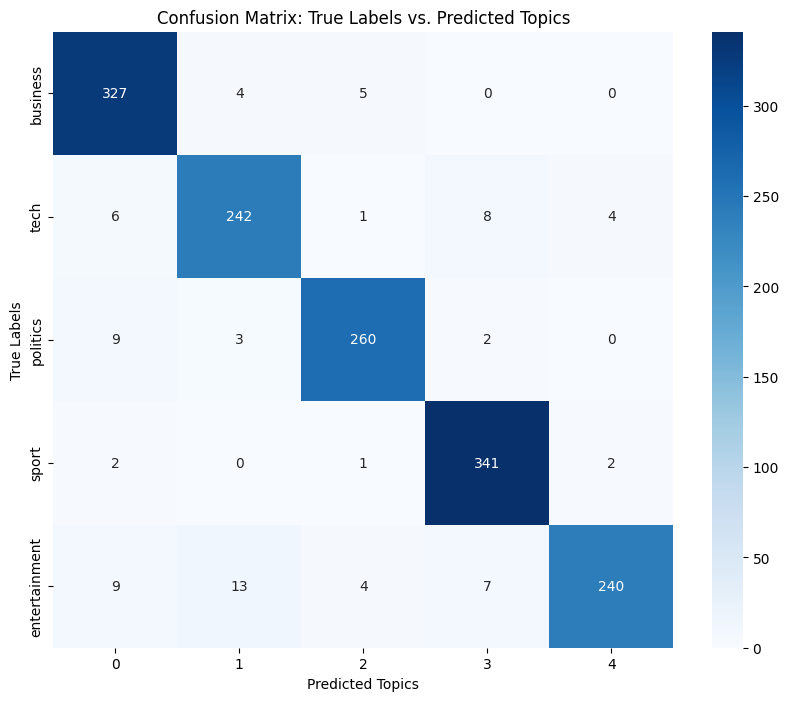

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(data.CategoryId, data['aligned_topic']), 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_topics), yticklabels=target_names)
plt.title('Confusion Matrix: True Labels vs. Predicted Topics')
plt.xlabel('Predicted Topics')
plt.ylabel('True Labels')

Overall, the model performs well, with a high number of correct classifications represented on the diagonal of the confusion matrix. However, for some individual classes, we observe the following:

- **Sport**: This category has the highest number of correctly classified documents (341) and very few misclassifications, indicating that the model is highly effective at identifying sports articles.

- **Entertainment**: This category has a similar number of correct classifications (246) as sports but shows more misclassifications, particularly with the tech and business categories. This suggests that the model may struggle to distinguish some entertainment articles from these topics.


## Model Tuning

By examining the top words, we can determine if adjustments to our model parameters (e.g., number of topics, initialization method) or preprocessing steps (e.g., stop words, n-grams) are necessary to enhance the quality of the identified topics.

We will update some of the NMF hyperparameters and evaluate the model's performance by checking the accuracy score. This iterative process helps us refine the model for better classification results.


In [16]:
# Here we set init method as 'random' and set solver method as 'mu'
nmf = NMF(init='random', n_components=num_topics, random_state=42, solver='mu')
topic_matrix = nmf.fit_transform(features)
data['predicted_topic'] = topic_matrix.argmax(axis=1)
topic_to_label = alignTopicToLabel()
data['aligned_topic'] = data['predicted_topic'].map(topic_to_label)
nmf_accuracy = accuracy_score(data.CategoryId, data['aligned_topic'])
# We will use nmf_accuracy to compare the nmf accuracy with the supervised learning models later
nmf_accuracy

0.9489932885906041

After modifying the model hyperparameters, the accuracy score of 0.9490 indicates a slight improvement. This suggests that while we have achieved better performance, further enhancements may be challenging, as it becomes increasingly difficult to improve accuracy when it is already high. This highlights the importance of focusing on other aspects of model performance, such as precision and recall, in addition to accuracy.


## Supervised Learning Models

Here, we will benchmark the following models:

- **Logistic Regression**: This statistical method predicts the probability of a binary outcome based on one or more independent variables. It is commonly used for classification tasks and can be extended to multi-class problems. Logistic Regression models the relationship between the features and the probability of belonging to a particular class using a logistic function.

- **Naive Bayes**: A probabilistic classifier based on Bayes' theorem, Naive Bayes assumes strong independence between features. It is straightforward to implement and performs well with text classification tasks. Naive Bayes calculates the probability of each class based on the given features and assigns the class with the highest probability.

- **Support Vector Machine (SVM)**: SVM aims to find the optimal hyperplane that separates data points into different classes. It is particularly effective for complex classification tasks with clear margins of separation between classes. SVM can handle both linear and non-linear data through the use of kernel functions.


To evaluate each of the models mentioned above, we will employ the cross-validation technique. This method involves splitting the dataset into multiple subsets, training the model on different subsets, and evaluating it on the remaining subset.

The `cross_val_score` function provided by scikit-learn is a valuable tool for obtaining a reliable estimate of a model's performance on unseen data. This approach helps avoid overfitting, saves time, and offers flexibility in evaluating various performance metrics.


<Axes: xlabel='model_name', ylabel='accuracy'>

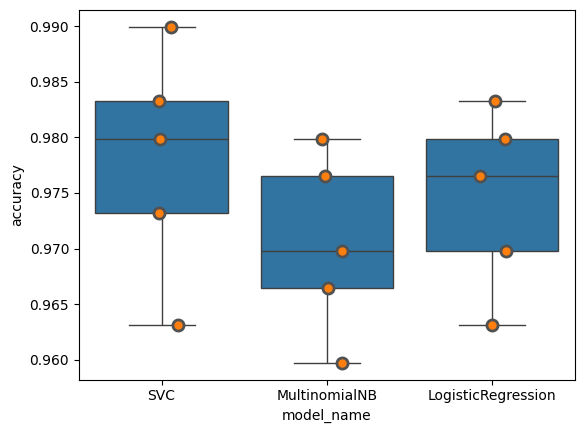

In [17]:
labels = data.CategoryId

models = [SVC(kernel='linear', gamma=5),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append([model_name, fold_idx, accuracy])
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, linewidth=2)

This boxplot compares the cross-validation accuracy scores for three different machine learning models: SVC (Support Vector Classifier), MultinomialNB (Multinomial Naive Bayes), and Logistic Regression. 

All three models perform well, with median accuracies exceeding 0.97. Notably, the SVC model appears to be the most accurate and consistent for this particular dataset and cross-validation setup, indicating its effectiveness in handling the classification task at hand.


### NMF Model vs. Supervised Learing Models

In [18]:
cv_df.loc[len(cv_df)] = ["NMF", 0, nmf_accuracy]
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.974497
MultinomialNB         0.970470
NMF                   0.948993
SVC                   0.977852
Name: accuracy, dtype: float64

Based on the above results, we can make the following observations:

- The supervised learning models exhibit very similar, high accuracy scores, ranging from 0.9704 to 0.9778, while the NMF model has a significantly lower accuracy score of 0.9490.
- The overall high accuracy scores suggest that the supervised models are performing well on the given dataset.
- The small differences in accuracy between the supervised learning models may not be statistically significant.
- The NMF model is primarily designed for dimensionality reduction and topic modeling, rather than classification, so its lower performance in this context is expected.


## Predict Test Dataset

Based on the accuracy benchmark, we will select the SVC model for predicting the test dataset. We will create the SVC model using the best hyperparameters found through GridSearch and then proceed to make predictions on the test dataset.


In [19]:
data_test_path = r"dataset/BBC_News_Test.csv"
data_test = pd.read_csv(data_test_path)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(features)
y_train = data.CategoryId

# Create the SVC model with GridSearchCV searched best parameters(finished running offline)
svc = SVC(C = 0.1, kernel='linear', gamma=5, random_state=42)

# Fit the grid search to the data
svc.fit(X_train, y_train)

# Extract test features from test dataset
features_test = vectorizer.fit_transform(data_test.Text).toarray()

# Make predictions on the test set
features_test = scaler.transform(features_test)
category_ids = svc.predict(features_test)

# Convert each category id to category name
categories = [id2category[id] for id in category_ids]
# Create test set prediction file
final_dict = {"ArticleId": data_test.ArticleId, "Category":categories}
final_df = pd.DataFrame(final_dict)
final_df.to_csv('submission.csv',index=False)

final_df.head()

,ArticleId,Category
0,1018,sport
1,1319,politics
2,1138,entertainment
3,459,tech
4,1020,sport
